# Getting to Know the Data 

### Primary Goal: Familiarize yourself with the dataset

In this notebook, I cover the following: 
* How to load the dataset 
* Plotting the individual features 
* Plotting the expected relationship between a feature and the target variable. 


In [1]:
# Import packages 
import pandas as pd
import numpy as np

# Plotting code imports 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
from main.io import load_ml_data, load_bl_data

from bayeshist import bayesian_histogram, plot_bayesian_histogram

In [2]:
# Configuration variables (You'll need to change based on where you store your data)
base_path = '/work/mflora/ML_2TO6HR/data'

### Step 1.  Load the ML Dataset

The machine learning dataset is in a [feather-style format](https://arrow.apache.org/docs/python/feather.html), which is fast format for [Pandas DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). I've provided a function that will load the dataframe into a scikit-learn ready format. For these examples, we will look at how data based on its relationship with severe hail (at a 36 km scale). 

<div class="alert alert-block alert-warning"> When using this notebook, evaluate different targets (i.e., target_col) </div>


In [3]:
X,y,metadata = load_ml_data(base_path=base_path, 
                            mode='train', 
                            target_col='hail_severe__36km')

### Details about the dataset 

The input features are based on environmental and storm fields from the Warn-on-Forecast System (WoFS) while the target variables are based on [Storm Data](https://www.ncdc.noaa.gov/stormevents/), which are vetted reports of severe weather hazards (e.g., tornadoes, severe wind, and severe hail). 

The environmental variables include: 
* 0-1, 0-6, and 3-6 U,V Wind Shear 
* Mid- and low-level lapse rate 
* Mixed-layer CAPE
* Mixed-layer CIN
* Significant Tornado Parameter
* Supercell Composite Parameter
* 0-3 Storm Relative Helicity 

The storm variables include: 
* 0-2 and 2-5 km Updraft Helicity 
* Composite Reflectivity 
* 0-2 km Avg. Vertical Vorticity 
* 80-m wind speed 
* Column-maximum Updraft 
* HAILCAST 
* Okubo-Weiss Number 

The native WoFS domain has a 3-km grid spacing. For this project, we initially upscaled the data to 9 km grid (to limit data processing). The environmental fields were upscaled using a local averaging filter while the storm fields were upscaled using a local maximum value filter, which is consistent with [Sobash et al. 2020](https://journals.ametsoc.org/view/journals/wefo/35/5/wafD200036.xml). To collapse the time dimension, we computed the time-average value for the environment fields and the time-maximum value for the storm fields, which is consistent with [Loken et al. 2020](https://journals.ametsoc.org/view/journals/wefo/35/4/wafD190258.xml). 

Unlike previous studies, we extracted features at multiple spatial scales (9, 27, and 45 km scales). One secondary goal of this project is evaluate whether having features at different spatial scales improves the model performance. We know that convolution neural networks leverage spatial pooling to extract features at different spatial scales, which improve their model performance. 

To collapse the ensemble dimension, we computed the ensemble mean and standard deviation for the environmental fields and the ensemble 90th percentile for the storm fields. 


#### Target variables 

Target variables include whether a tornado, hail, and/or wind report has occured within a certain distance of the grid point of interest. The reports are available at three different spatial scales (9, 15, and 36 km). The reports on based on severe and significant severe for each hazard type. 


In [4]:
# Uncomment and run this command to learn about the input args for the load_ml_data function.
#help(load_ml_data)

In [5]:
# Uncomment and run to see the full list of features. 
#list(X.columns)

# Here is the breakdown for the naming convention 
# [feature_name]__[time_max|time_avg]__[9|27|45]km__[ens_90th|ens_mean|ens_std]

### Step 2. Explore the features 

In this section, we can plot the distribution of values for different features. Getting a sense for the skewedness, the range of values, etc helps us better understand the data.  Plotting the data can also expose issues with the data.


In [6]:
# These are the variables we are going to plot. 
variables = ['scp__time_avg__9km__ens_mean',
             'cape_ml__time_avg__9km__ens_mean',
             'shear_u_0to6__time_avg__9km__ens_std',
             'hailcast__time_max__45km__ens_90th',
             'shear_v_3to6__time_avg__27km__ens_mean',
             'w_up__time_max__27km__ens_90th',
            ]

# This list should match "variables", but contain 
# prettier, display names (we like pretty plots!)
mapper = ['Ens. Mean\nSupercell Comp. Param. (9 km)', 
          'Ens Mean\nML CAPE (9 km)',
          'Ens Std\n0-6 km U-Shear (9 km)', 
          'Ens. Mean\nPeak Hail Size (45 km)', 
           'Ens. Mean\n3-6 km V-Shear (27 km)',
          'Ens Mean\nPeak Updraft (27 km)',
            ]

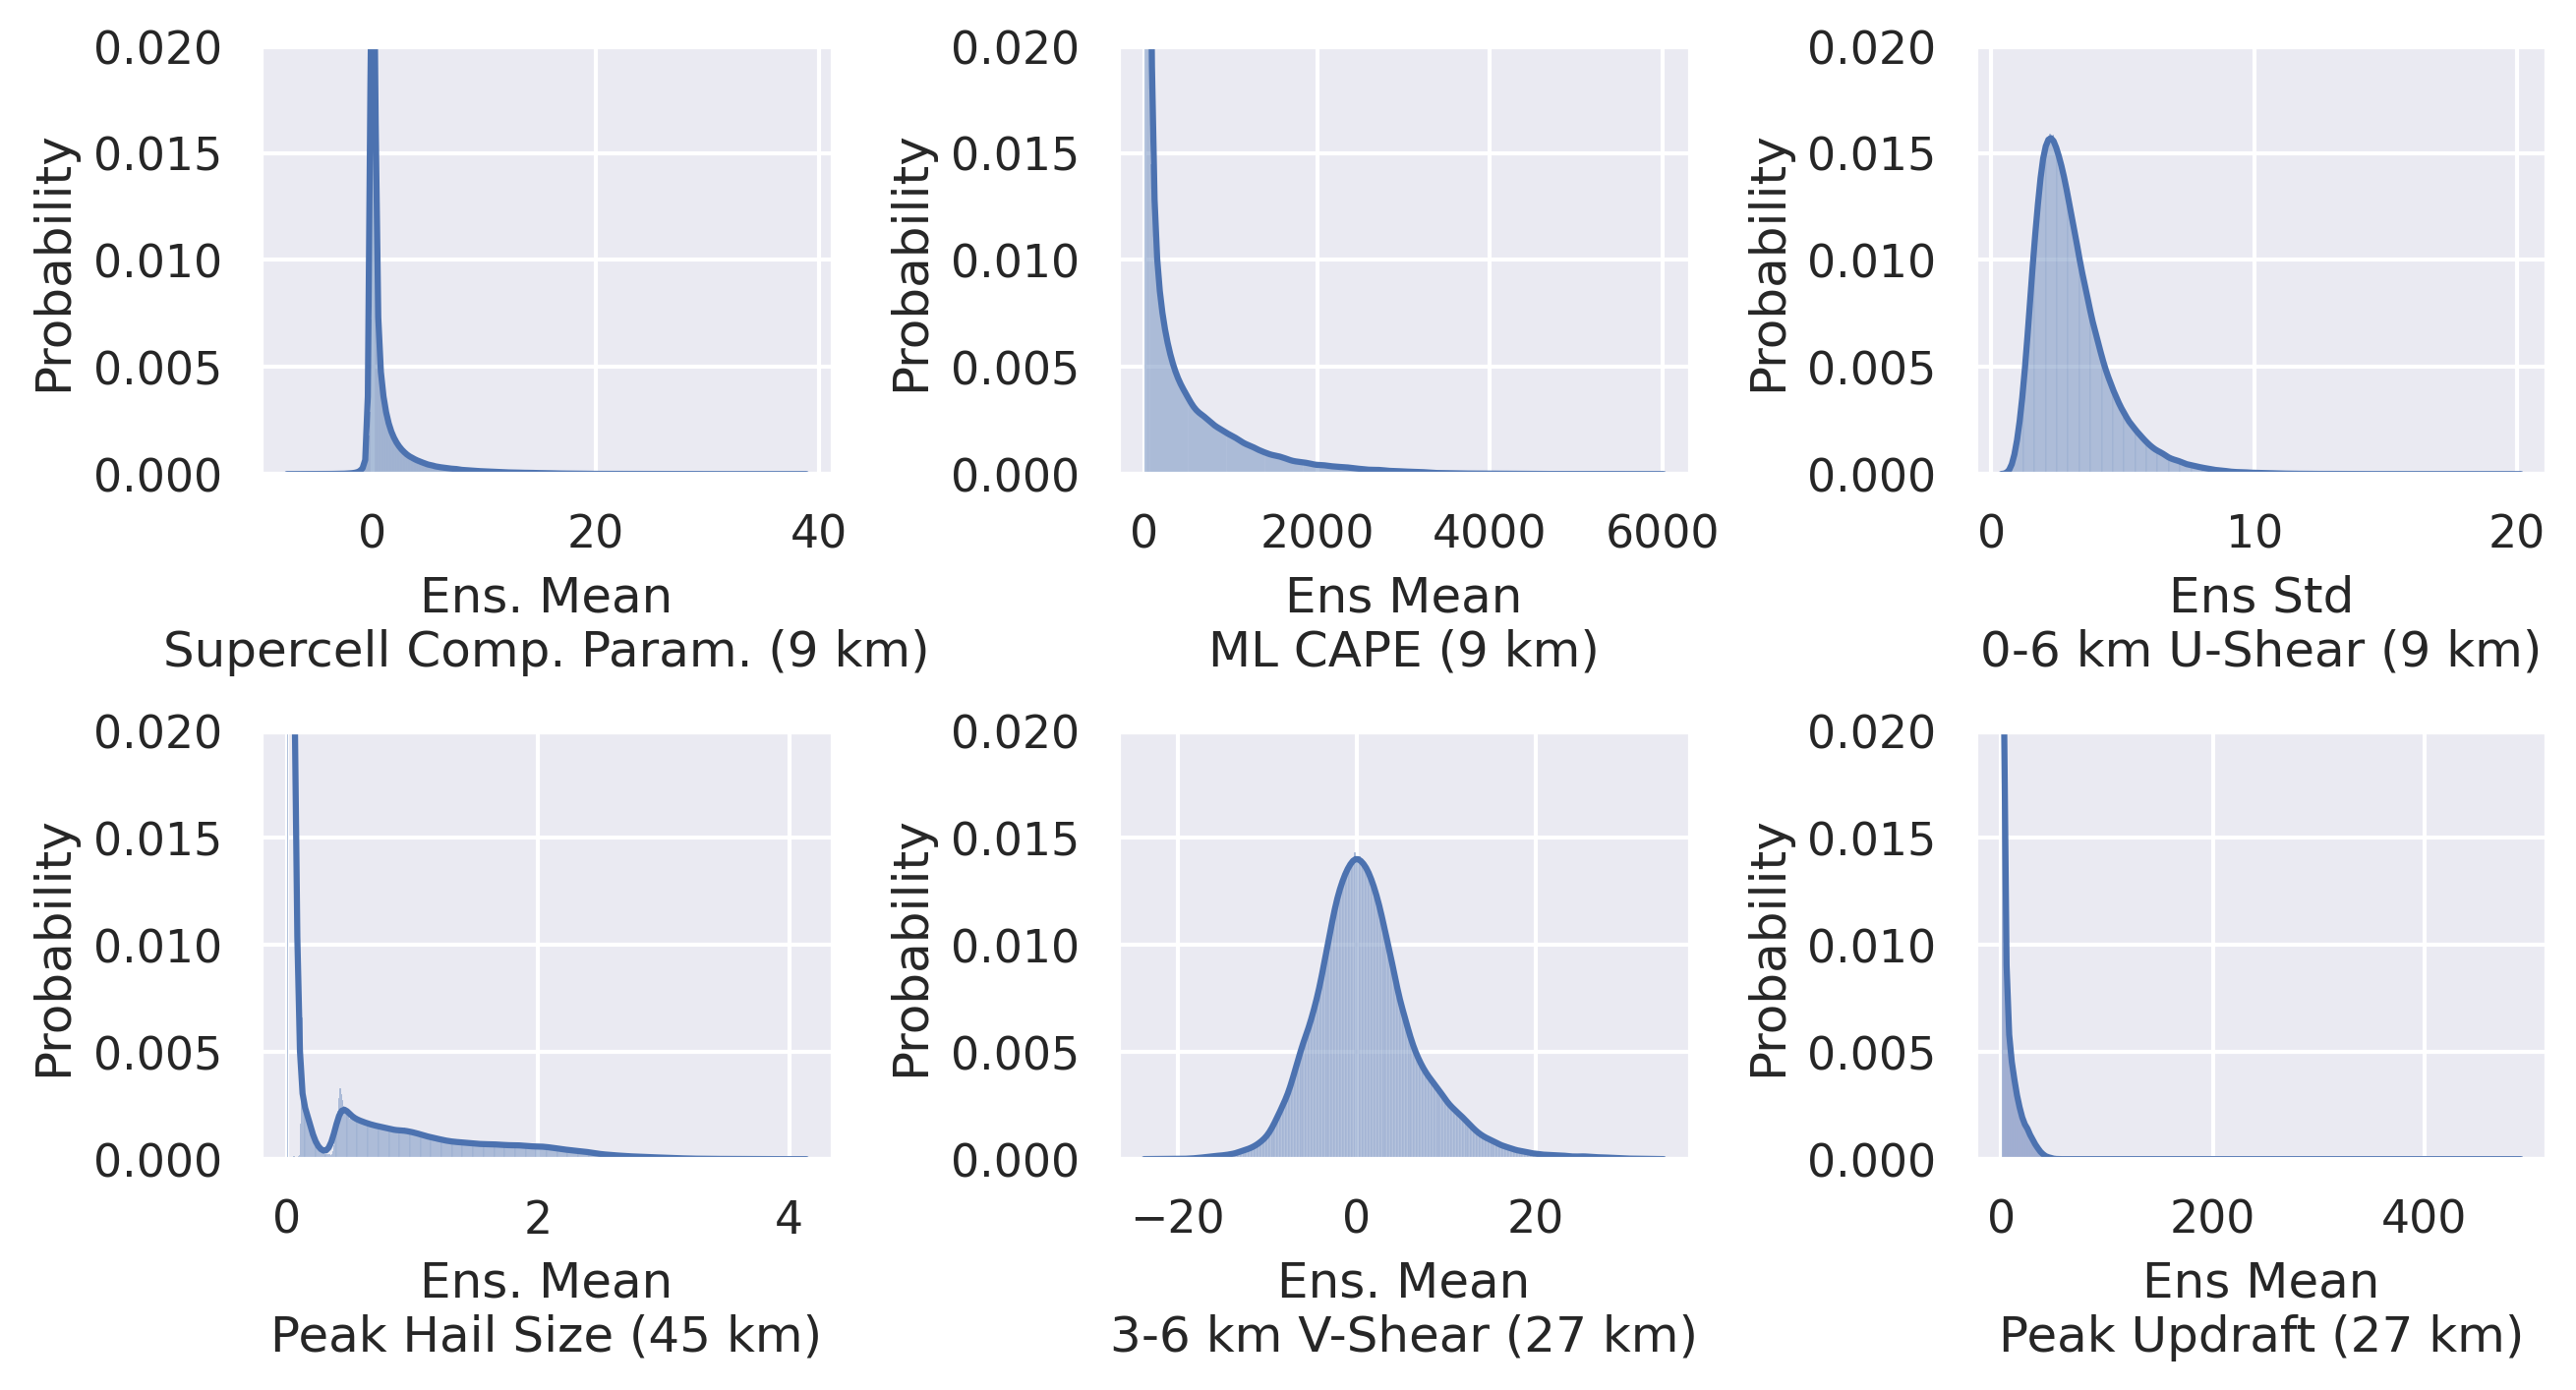

In [7]:
# Create a plotting panels. 
fig, axes =plt.subplots(dpi=300, ncols=3, nrows=2, figsize=(10,5))

# The dataset has 2.7 million examples. To reduce the dataset for plotting purposes, 
# we can subsample the data. In this example, I'm taking a random 50K examples.
inds = np.random.choice(X.shape[0], 500000, replace=False)
X_sub = X.iloc[inds]
X_sub.reset_index(drop=True, inplace=True)

# This is main plotting code. We are using the histplot for the seaborn package. 
for i, (v, ax) in enumerate(zip(variables, axes.flat)):
    sns.histplot(data=X_sub, x=v, ax=ax, kde=True, stat='probability')
    ax.set_xlabel(mapper[i])
    ax.set_ylim([0, 0.02])
    
plt.subplots_adjust(wspace=0.5, hspace=0.6) 

The ensemble mean 3-6 km V-shear is normally distributed, but the other features are highly skewed. Remember that these data are collected from various grid points in the Warn-on-Forecast System (WoFS) domain. Most of those points will not experience an updraft, hail, or a storm in general. 

There are two issues we can see: 
* The supercell composite parameter (SCP) has negative values (upper left panel). Typically SCP is a positive quantity. However, WoFS allows for negative SRH values which can result in negative SCP values. 
* Some of the peak updraft speeds are in the 200-400 m/s range (bottom right panel). Since we wouldn't expect physical updraft speed within in storms to exceed 50 m/s this is clearly an error. Unfortunately, artifacts on the domain boundaries can cause these unphysically large updraft speeds. 


<div class="alert alert-block alert-info"> <b>Question</b> Can you find any other issues in the dataset? An invaluable skill of a data scientist is cleaning up a dataset before applying machine learning </div>


In [8]:
# Let's see how many examples have an updraft speed > 50 m/s 
inds = np.where(X['w_up__time_max__27km__ens_90th'] > 50)[0]
len(inds)

622

Only 622 out of the 2.7 million examples have an excessive updraft speed. Before applying machine learning, it would be good to remove these examples and remove other examples with problemsome data. I leave this as an exercise for you. 

### Step 3. Explore the features and their relationship with the target variable.

Becoming familiar with the relationship between the features and the target variable is also a good first step. In this example, we compute the event rate using a [Bayesian Histogram Method](https://dionhaefner.github.io/2021/09/bayesian-histograms-for-rare-event-classification/). The event rate is the probability of the target variable equaling 1 given the value of a particular feature.  



/home/monte.flora/miniconda3/envs/reu/lib/python3.8/site-packages/bayeshist/bayeshist.py:43: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(


Text(0.04, 0.5, 'Event Rate $[P(y=1|X)]$')

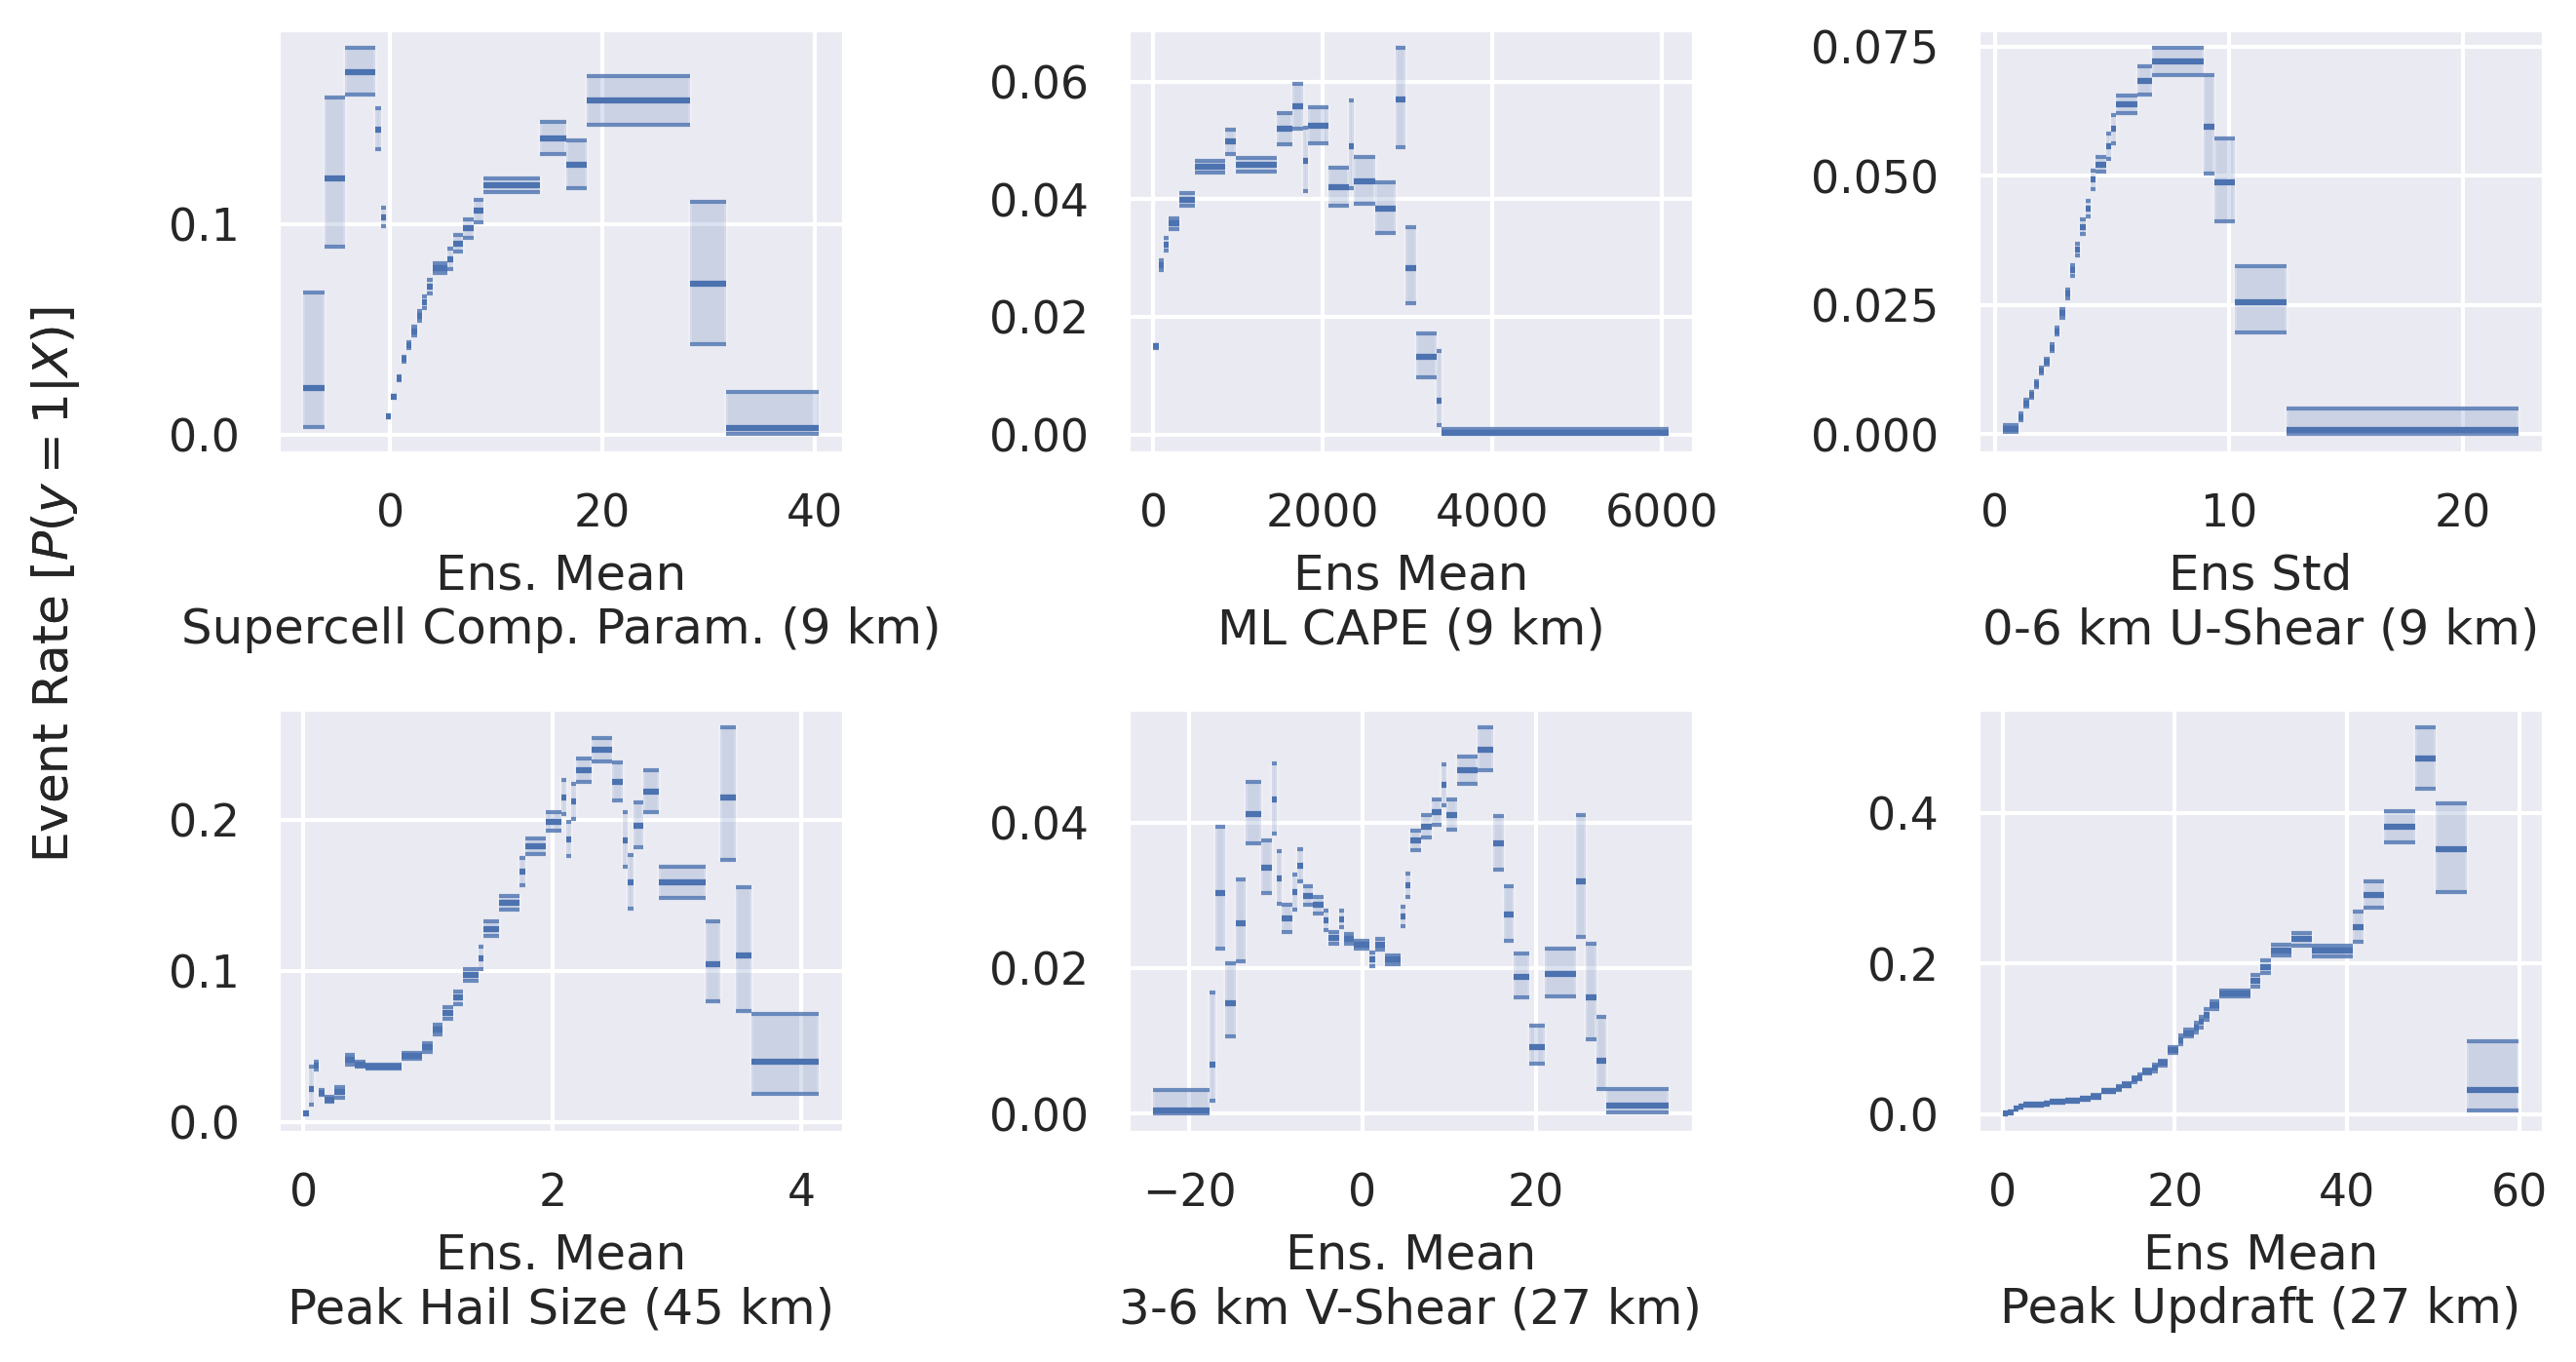

In [9]:
# Create a plotting panels. 
fig, axes =plt.subplots(dpi=300, ncols=3, nrows=2, figsize=(10,5))

inds = np.where(X['w_up__time_max__27km__ens_90th'] < 60)[0]
X_sub = X.iloc[inds]
X_sub.reset_index(drop=True, inplace=True)
y_sub = y[inds]

for i, (v, ax) in enumerate(zip(variables, axes.flat)):
    data = X_sub[v].values.astype(float)
    bin_edges, beta_dist = bayesian_histogram(data, y_sub)
    plot_bayesian_histogram(bin_edges, beta_dist, ax=ax)

    ax.set_xlabel(mapper[i])
    
plt.subplots_adjust(wspace=0.5, hspace=0.6) 

fig.text(0.04, 0.5, r'Event Rate $[P(y=1|X)]$', va='center', rotation='vertical')
plt.subplots_adjust(wspace=0.5, hspace=0.6) 

fig.text(0.04, 0.5, r'Event Rate $[P(y=1|X)]$', va='center', rotation='vertical')

From these plots, we can conclude the following: 
   * Increasing SCP, either negative or positive results in higher severe hail probability. This is reasonable as both left- and right-moving supercells can be prolific hail producers. 
   * Increasing CAPE increases the severe hail probability, but too high of CAPE and the probability goes down. Updraft speed is related to CAPE and if the updraft is too strong, then large hail does not form as it is ejected before it can increase in size. 

<div class="alert alert-block alert-info"> <b>Question</b> Do the other relationships with severe hail make sense? </div>

<div class="alert alert-block alert-success"> <b>Task:</b> Check that the relationships make sense for the other hazards </div>

